In [33]:
import pymatgen as pmg
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.core.periodic_table import Element
from pymatgen.electronic_structure.core import Spin, Orbital
from pymatgen.electronic_structure.dos import Dos, DOS
import functools
import numpy as np

from os.path import expanduser
home = expanduser('~')

from matplotlib.pyplot import figure

import matplotlib.pyplot as pyplot
from scipy.integrate import trapz, simps

import warnings
warnings.filterwarnings("ignore")


def integrate(axis, start, end):
    """Integrates the given DoS data"""
    d_line = axis.get_lines()[1]
    x = d_line.get_xdata()[start:end]
    y = d_line.get_ydata()[start:end]
    pyplot.plot(x,y)
    return(simps(y,x))


def norm_dos(dos, factor):
    dos_dict = dos.as_dict()
    for key in dos_dict['densities'].keys():
        dos_dict['densities'][key] = np.array(dos_dict['densities'][key])/factor
    return Dos.from_dict(dos_dict)

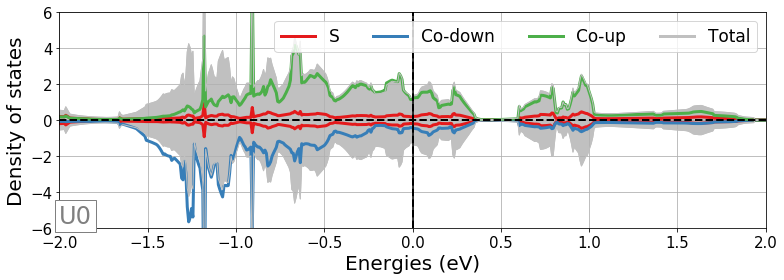

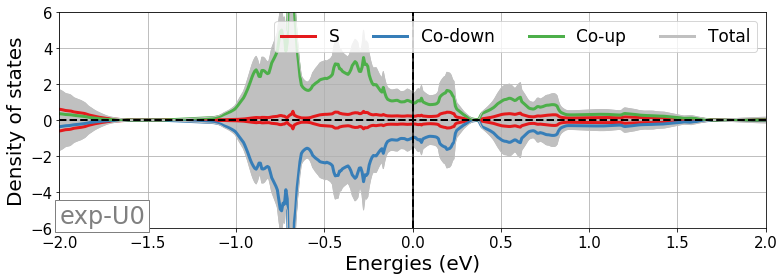

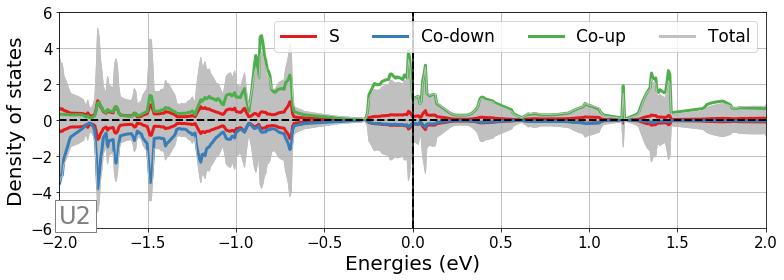

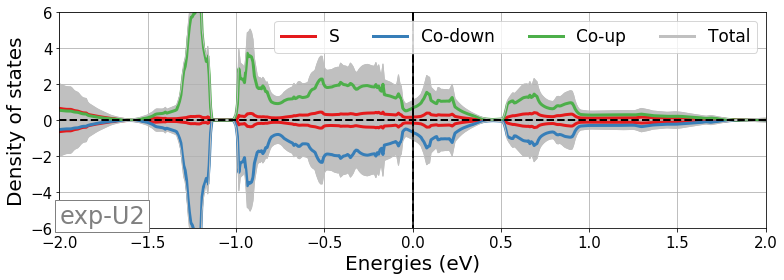

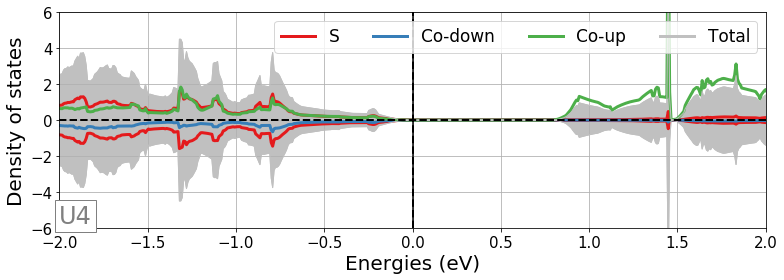

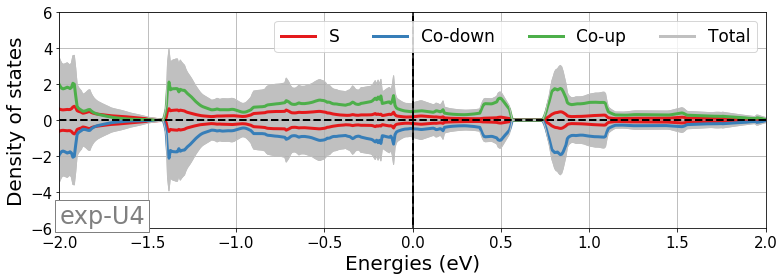

In [38]:
WIDTH = 11
HEIGHT = 4

DOS_TYPE = 'site-spin' #'element'
BY_ELEMENT = ["S"]
BY_SITE = [5]
ORBITALS_LS = [[4, 5, 6, 7, 8]] #desired orbitals corresponding to sites listed
NORM_FACTOR=4

PREFIX = home + '/Projects/BaCoS2/correct_mag/estruc/vasprun-dos'
SUFFIX = ".xml"
ITERS_1 = ['U0', 'exp-U0', 'U2', 'exp-U2', 'U4', 'exp-U4']

# ITERS_2 = ['og', 'rlx']
LABELS_1 = ITERS_1
# LABELS_2 = ITERS_2
LABEL_PREFIX = ""
XLIMS = [[-2,2]]*12
YLIMS = [[-6,6]]*12
LABEL_FONT = 20

axes = []

for i, iter_1 in enumerate(ITERS_1):
#     for j, iter_2 in enumerate(ITERS_2):
        
        label = f'{iter_1}'
        
            # Extract dos from vasprun
        vr = Vasprun(f'{PREFIX}-{label}{SUFFIX}')
        cdos = vr.complete_dos
        tdos = norm_dos(vr.tdos, 4)
        
        dplt = DosPlotter()

            # Add total dos
        dplt.add_dos("Total", tdos)
        
            # Add site doss
        pdoss = cdos.pdos
        for site_idx, orbitals in zip(BY_SITE, ORBITALS_LS):
            site = cdos.structure[site_idx]
            elem = site.species.elements[0]
            efermi = cdos.efermi
            energies = cdos.energies
            for spin, spin_label in [(Spin.up, 'up'), (Spin.down, 'down')]:
                spin_doss = (pdoss[site][Orbital(orb_num)][spin] for orb_num in orbitals)
                
                dplt.add_dos(f'{elem}-{spin_label}', 
                             Dos(efermi, energies, {spin: sum(spin_doss)}))
                
        #         if DOS_TYPE == 'site':
        #             for site_idx in SITES:
        #                 site = cdos.structure[site_idx]
        #                 elem = cdos.structure[2].species.elements[0]
        #                 dos = cdos.get_site_dos()
        #                 dplt.add_dos(elem, dos)

            # Add element dos
        elem_doss = cdos.get_element_dos()
        for element in BY_ELEMENT:
            dplt.add_dos(element, norm_dos(elem_doss[Element(element)], 4))

            # Customize plot
        dos_plot = dplt.get_plot()
        dos_plot.xlim(XLIMS[i])
        dos_plot.ylim(YLIMS[i])
        dos_plot.axvline(x=0, color='k', linestyle='-')
        dos_plot.grid(1)

            # Make total line grey and filled in
        totLine = dos_plot.gca().get_lines()[3]
        totLine.set_color('silver')

        dos_plot.legend(loc='upper right', ncol=6, fontsize=LABEL_FONT-3) #keep line thick in legend

        totLine.set_linewidth(1)   

        totX = totLine.get_xdata()
        totY = totLine.get_ydata()

        dos_plot.fill_between(totX, totY, where=totY>=-totY, interpolate=True, color='silver')
        dos_plot.fill_between(totX, totY, where=totY<=-totY, interpolate=True, color='silver')


            # Add a label to bottom right
        t = dos_plot.text(0.0, 0.0, LABEL_PREFIX + label, horizontalalignment='left', 
                      verticalalignment='bottom', transform=dos_plot.gca().transAxes, 
                      fontsize=24, color='grey')
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='grey'))
            # Chance font size
        dos_plot.gca().xaxis.label.set_fontsize(LABEL_FONT)
        dos_plot.gca().yaxis.label.set_fontsize(LABEL_FONT)
        pyplot.xticks(fontsize=LABEL_FONT-5)
        pyplot.yticks(fontsize=LABEL_FONT-5)

            # Add axes to persistent list
        axes.append(dos_plot.gca())


            # Resize/reshape
        fig = dos_plot.gcf()
        fig.set_size_inches(WIDTH,HEIGHT)

            # Show and save
        dos_plot.tight_layout()
        dos_plot.show()
        fig.savefig(f"elec_dos-{label}.png", img_format="png", dpi=300)
        fig.savefig(f"elec_dos-vec-{label}.pdf", img_format="pdf")

d1 - 0.08352299999999992


IndexError: list index out of range

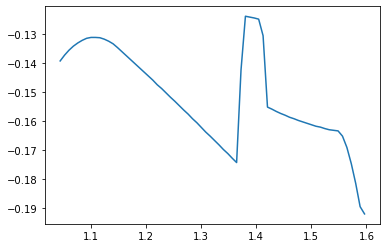

In [35]:
start = 1150
end = 1220

print(f'd1 - {integrate(axes[-1], start, end)}')
print(f'd065 - {integrate(axes[5], 1250, 1350)}')


In [ ]:
6002-4900